In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import datetime
import regex as re

from networkx.algorithms.flow import shortest_augmenting_path

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config Completer.use_jedi = False

data = 'https://raw.githubusercontent.com/itsgorain/datasets/main/networks/kpop/kpop_edgelist.csv'

In [2]:
def remove_punctuation(my_str):
    return re.sub(r'[^\w\s]', '', my_str) 

In [3]:
def get_df(data):
    
    network_df = pd.read_csv(data)

    network_df['source'] = network_df['source'].str.lower()
    network_df['target'] = network_df['target'].str.lower()

    network_df['source'] = network_df['source'].apply(remove_punctuation)
    network_df['target'] = network_df['target'].apply(remove_punctuation)
    network_df['source'] = '@' + network_df['source']
    network_df['target'] = '@' + network_df['target']

    return network_df

In [4]:
def draw_graph(G, show_names=False):
    
    import numpy as np
    from IPython.display import SVG
    from sknetwork.visualization import svg_graph
    from sknetwork.data import Bunch
    from sknetwork.ranking import PageRank
    
    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr')
    names = np.array(list(G.nodes()))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)

    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)
    
    if show_names:
        image = svg_graph(graph.adjacency, font_size=9, node_size=0, names=graph.names, width=700, height=500, scores = scores, edge_width=0.3)
    else:
        image = svg_graph(graph.adjacency, node_size=0.5, width=700, height=500, scores = scores, edge_width=0.3)
    
    return SVG(image)

In [5]:
def print_graph_info(G):
    print(nx.info(G))

In [6]:
network_df = get_df(data)
network_df.tail()

,source,target
217,@bravegirls_,@kpopggsuperior
218,@arenahommeplus,@pledis_17
219,@jypetwice,@twicetly
220,@rbw_purplekiss,@kpopggsuperior
221,@cubeclc,@kpopggsuperior


In [7]:
network_df = network_df[network_df['source'] != '@']

# fix problems
network_df['source'] = network_df['source'].str.replace('@blackpinks', '@blackpink')
network_df['source'] = network_df['source'].str.replace('@sf9official現場でパシャパシャ', '@sf9official')

# cleanup
network_df.drop_duplicates(inplace=True)

network_df.head()

,source,target
0,@wannaoneofficial,@wannaone_twt
1,@hyoyeon_djhyo,@rvsmtown
2,@applemusic,@blackpink
3,@spotify,@blackpink
4,@blackpink,@blackpink


In [25]:
# find top connected source nodes
sorted(network_df.groupby('source').count().sort_values('target', ascending=False)[0:20].index)

['@applemusic',
 '@blackpink',
 '@bravegirls_',
 '@bts_bighit',
 '@bts_twt',
 '@got7official',
 '@itzyofficial',
 '@justinbieber',
 '@jypetwice',
 '@kr_now',
 '@latelateshow',
 '@picsartstudio',
 '@recordingacad',
 '@rvsmtown',
 '@shopeeid',
 '@spotify',
 '@spotifykr',
 '@ygselect',
 '@zanelowe',
 '@zepeto_official']

In [26]:
network_df.shape

(204, 2)

In [27]:
G = nx.from_pandas_edgelist(network_df, create_using=nx.Graph)
G.remove_edges_from(nx.selfloop_edges(G))

In [28]:
print_graph_info(G)

Name: 
Type: Graph
Number of nodes: 171
Number of edges: 193
Average degree:   2.2573


In [29]:
# just showing how simple it is to remove junk, but you can also do it at the dataframe

drop_nodes = ['#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10', '@']

G.remove_nodes_from(drop_nodes)

In [30]:
cent_df = pd.DataFrame(nx.eigenvector_centrality(G), index=[0]).T
cent_df.columns = ['cent_value']
cent_df.sort_values('cent_value', ascending=False, inplace=True)
cent_df.head(10)

,cent_value
@zanelowe,0.485503
@spotifykr,0.388149
@blackpink,0.334167
@ygofficialblink,0.194106
@bts_bighit,0.186326
@applemusic,0.185710
@spotify,0.137106
@justinbieber,0.128209
@jypetwice,0.108204
@ygselect,0.097736


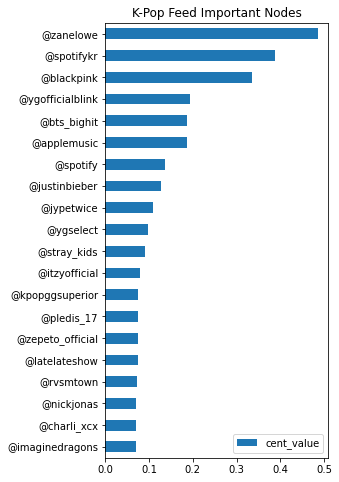

In [31]:
cent_df[0:20].plot.barh(figsize=(4, 8), title='K-Pop Feed Important Nodes')
plt.gca().invert_yaxis()

In [32]:
# top 30 users by centrality

sorted(cent_df[cent_df.index.str.contains('@')][0:30].index)

['@applemusic',
 '@blackpink',
 '@bts_bighit',
 '@charli_xcx',
 '@danreynolds',
 '@gwenstefani',
 '@iamjoellittle',
 '@imaginedragons',
 '@itzyofficial',
 '@jheneaiko',
 '@jonbatiste',
 '@justinbieber',
 '@jypetwice',
 '@kpopggsuperior',
 '@lanadelrey',
 '@latelateshow',
 '@liltjay',
 '@nickjonas',
 '@no_rome',
 '@pledis_17',
 '@rvsmtown',
 '@slowthai',
 '@spotify',
 '@spotifykr',
 '@stray_kids',
 '@whoisaddison',
 '@ygofficialblink',
 '@ygselect',
 '@zanelowe',
 '@zepeto_official']

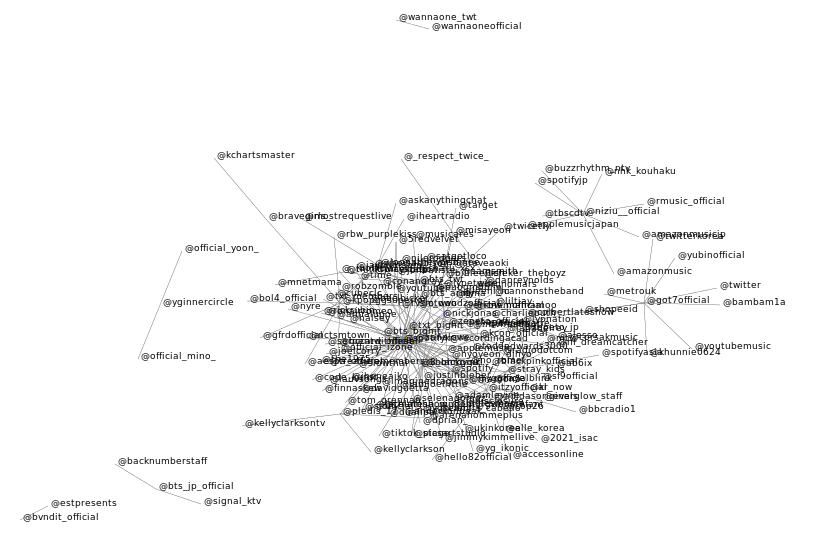

In [37]:
k_cutoff = 1 # nothing will be less than 1 due to how network was built; increase to see core nodes

draw_graph(nx.k_core(G, k_cutoff), show_names=True)

In [38]:
# what does BTS centric network look like

def draw_group_graph(group):

    mask = network_df['source'].str.contains(group) | network_df['target'].str.contains(group)

    G_small = nx.from_pandas_edgelist(network_df[mask])
    
    return draw_graph(G_small, show_names=True)

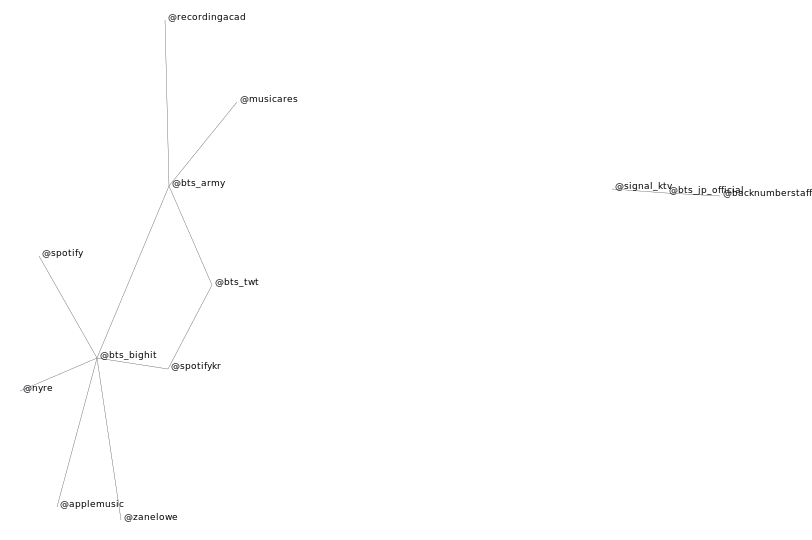

In [39]:
draw_group_graph('bts')

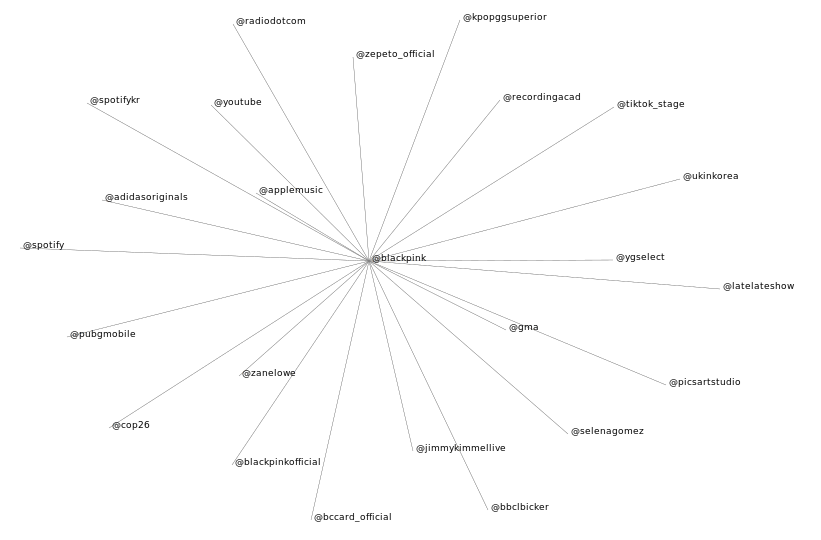

In [40]:
draw_group_graph('pink') # blackpink is much more connected than bts

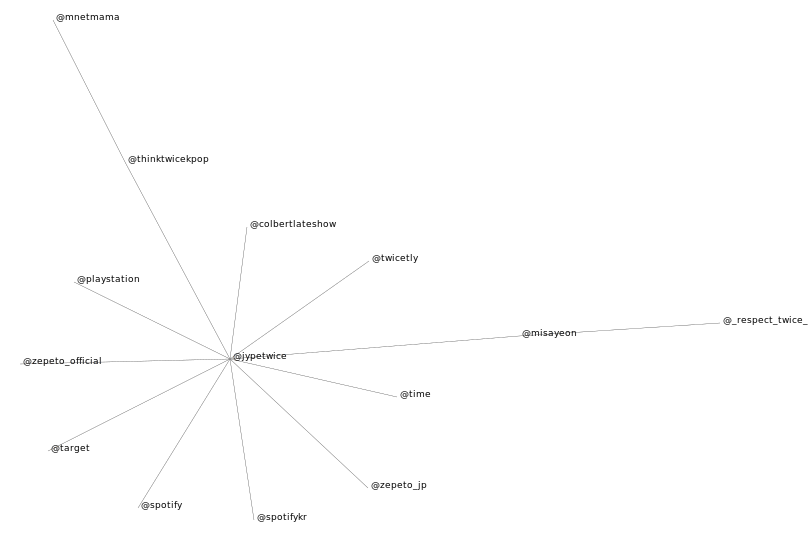

In [41]:
draw_group_graph('twice')

In [42]:
# disconnected pieces of a network will show up as separate components; like islands/countries

components = sorted(nx.connected_components(nx.k_core(G, k_cutoff)))

In [43]:
components[3] # inspect components by n if you want to see what is in them

{'@amazonmusic',
 '@amazonmusicjp',
 '@applemusicjapan',
 '@buzzrhythm_ntv',
 '@nhk_kouhaku',
 '@niziu__official',
 '@rmusic_official',
 '@spotifyjp',
 '@tbscdtv'}

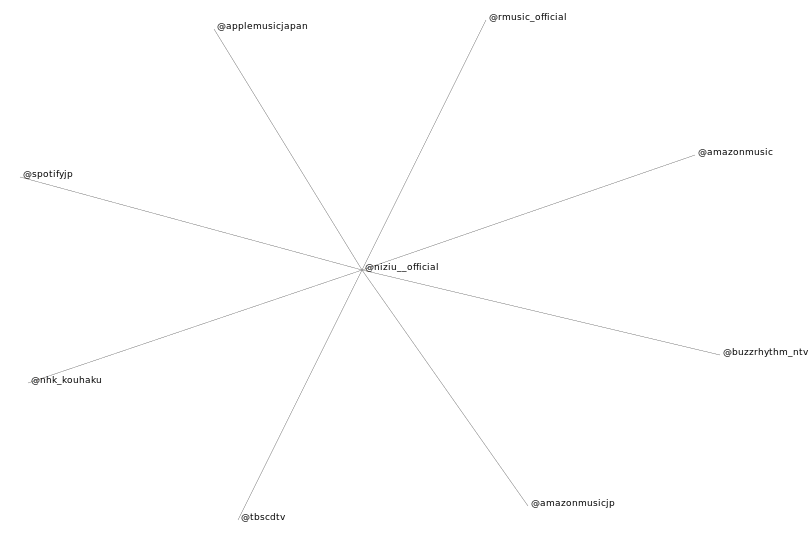

In [44]:
draw_graph(G.subgraph(components[3]), show_names=True)

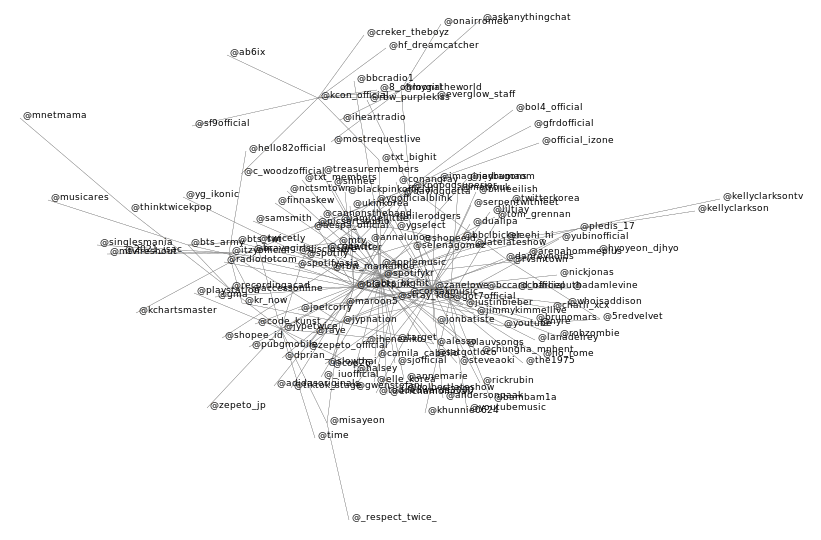

In [45]:
draw_graph(G.subgraph(components[1]), show_names=True)